In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from collections import Counter
from importlib.machinery import SourceFileLoader
from os.path import join
from torchtext.vocab import GloVe
import seaborn as sns

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import *
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords' ,quiet=True)
nltk.download('wordnet')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

import re

STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup


import os

# Web Scraping
import requests
from bs4 import BeautifulSoup

In [ ]:
# Google drive
from google.colab import files, drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd drive/MyDrive

[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [ ]:
# Read csvs
df_train = pd.read_csv("finance_train.csv")
df_test = pd.read_csv("finance_test.csv")

# Constants
PUNCTUATION = '!#$%&()*,-./:;<=>?@^_`{|}~'
PUNCTUATION_RE = re.compile("[%s]" % PUNCTUATION)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))


# # Hyperparameters - we didn't really end up using these, we used numbers instead
# MAX_NB_WORDS = None
# MAX_SEQUENCE_LENGTH = None
# EPOCHS = None
# EMBEDDING_DIM = None
# BATCH_SIZE = None

# Clean text - returns lowercase text with removed chars and stopwords
def clean_text(text:str):
    text = text.lower()
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    text = BAD_SYMBOLS_RE.sub('', text)
    text = text.replace('x', '')
    text = PUNCTUATION_RE.sub('', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) 
    return text

# Padding and indexing of unique words
def pad_sequences_train(train, test):
  tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters=PUNCTUATION, lower=True)
  tokenizer.fit_on_texts(train['Sentence'].values)
  word_index = tokenizer.word_index
  X = tokenizer.texts_to_sequences(train['Sentence'].values)
  X_train = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
  Xt = tokenizer.texts_to_sequences(test['Sentence'].values)
  X_test = pad_sequences(Xt, maxlen=MAX_SEQUENCE_LENGTH)
  return X_train, X_test

# Run model
def run_model(xtr, ytr, xt, yt, labelnum, epochs=5, max_sequence_length=256, max_nb_words=1000, embedding_dim=300):
  # Problematic input
  if any(x is None for x in [xtr, ytr, xt, yt, epochs, max_sequence_length, max_nb_words, embedding_dim]):
    print('Replace the None values above with your new values before calling the run_model() function.')
    return None, None, None
  
  # NN
  model = Sequential() # Container
  model.add(Embedding(max_nb_words+1, embedding_dim, mask_zero=True, input_length=max_sequence_length)) # Embedding
  model.add(SpatialDropout1D(0.2)) # Dropout
  model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2)) # LSTM layer
  model.add(Dense(labelnum, activation='softmax')) # Densely connected layer with softmax activation
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  # Performance
  print(model.summary())
  history = model.fit(xtr, 
                    ytr, 
                    epochs=epochs, 
                    batch_size=BATCH_SIZE,
                    validation_split=0.2,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])
  test_loss, test_accuracy = model.evaluate(xt, yt)
  return model, history, test_accuracy

# Softmax 
def softmax(model_output):
    ret = []
    for logits in model_output:
        total = sum(np.exp(logits))
        tmp = []
        for logit in logits:
            tmp.append(np.exp(logit)/total)
        ret.append(tmp)
    return ret

In [ ]:
# Get rid of unwanted characters and punctuation to reduce noise
df_train["Sentence"] = df_train["Sentence"].map(clean_text)
df_test["Sentence"] = df_test["Sentence"].map(clean_text)

In [ ]:
# Dataset view
df_train.head()

,Sentence,Label
0,autotank group part aspo systems division,1
1,contract includes design construction delivery...,1
2,rapala said estimates make savings 12 mln eur ...,2
3,share capital alma media corporation business ...,1
4,financial impact estimated 15 meur annual impr...,2


In [ ]:
# Dataset view
df_test.head()

,Sentence,Label
0,third quarter 2010 net sales increased 52 eur ...,2
1,foundries division reports sales increased 97 ...,2
2,financing project come mainly china,1
3,sukhraj dulai 2900 block boni sue court culdes...,1
4,finland leading metals group outokumpu said fo...,2


In [ ]:
# Pad X train and X test, with the model fitted to X train
X_train, X_test = pad_sequences_train(df_train, df_test)
X_train

array([[  0,   0,   0, ..., 347,  91, 161],
       [  0,   0,   0, ..., 285,  93, 484],
       [  0,   0,   0, ...,  39, 185, 654],
       ...,
       [  0,   0,   0, ...,  32,  11,  16],
       [  0,   0,   0, ...,  11,  94,  15],
       [  0,   0,   0, ..., 909,  33, 218]], dtype=int32)

In [ ]:
X_test

array([[  0,   0,   0, ...,   4,   1,   2],
       [  0,   0,   0, ...,  32,  11,  31],
       [  0,   0,   0, ..., 786, 534, 270],
       ...,
       [  0,   0,   0, ...,  25, 954, 363],
       [  0,   0,   0, ..., 536, 931,  27],
       [  0,   0,   0, ...,   2,   1,   2]], dtype=int32)

In [ ]:
# Get dummies to turn labels into a format where it can be processed by a probabilistic model
Y_train = pd.get_dummies(df_train["Label"]).values
Y_test = pd.get_dummies(df_test["Label"]).values
Y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0]], dtype=uint8)

In [ ]:
Y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [1,

In [ ]:
# Initialize model
label_count = 3
label_map = {0:"negative", 1:"neutral", 2:"positive"}

model, history, test_accuracy = run_model(X_train, Y_train, X_test, Y_test, label_count, 5, 256, 1000, 300)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 300)          300300    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 256, 300)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 461,003
Trainable params: 461,003
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
51/51 [==============================] - 34s 625ms/step - loss: 0.8317 - accuracy: 0.7017 - val_loss: 0.6619 - val_accuracy: 0.7475
Epoch 2/5
51/51 [==============================] - 32s 619ms/step - loss: 0.4720 - accuracy: 0.8103

In [ ]:
# Scrape BBC News for company activities
r1 = requests.get("https://www.bbc.com/news/business/companies")
coverpage = r1.content

soup1 = BeautifulSoup(coverpage, 'html5lib')
coverpage_news = soup1.find_all('h3')
filtered_news = []

# If a company wants to see how their name is doing, they can pass their company name/keywords into the function
def get_filtered_news(company_name:str=None):
  if company_name: company_name = company_name.lower()
  for news in coverpage_news:
    line = news.get_text().lower()
    if company_name and company_name in line:
      filtered_news.append(line)
    elif not company_name:
      filtered_news.append(line)

get_filtered_news()

print(filtered_news[:10])

["takeover of uk tech firm 'raises serious concerns'", "takeover of uk tech firm 'raises serious concerns'", 'm&s says recovery plan boosting sales and profits', "morrisons backs us firm's improved takeover offer", 'apple delays return to the office until 2022', 'onlyfans to ban sexually explicit content', "amazon 'planning to open department stores in us'", 'lloyds aiming to become giant uk landlord', "takeover of uk tech firm 'raises serious concerns'", 'm&s says recovery plan boosting sales and profits']


In [ ]:
# preprocess data
filtered_news = pd.DataFrame(filtered_news, columns=["Sentence"]).Sentence.map(clean_text)
print(type(filtered_news))
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters=PUNCTUATION, lower=True)
tokenizer.fit_on_texts(df_train['Sentence'].values)
Xn = tokenizer.texts_to_sequences(filtered_news.values)
X_new = pad_sequences(Xn, maxlen=MAX_SEQUENCE_LENGTH)
print(X_new.shape)

<class 'pandas.core.series.Series'>
(66, 256)


In [ ]:
preds = model.predict(X_new)
softmax_preds = softmax(preds)
softmax_preds[:10]

[[0.26097461389843385, 0.42273424548240246, 0.3162911406191637],
 [0.26097461389843385, 0.42273424548240246, 0.3162911406191637],
 [0.2501424054795962, 0.2826346438876367, 0.4672229506327671],
 [0.24308772075080287, 0.2444590522536492, 0.512453226995548],
 [0.21520601790283897, 0.5673704816027478, 0.2174235004944132],
 [0.22256167198383364, 0.5549039539590436, 0.22253437405712279],
 [0.2808072193635048, 0.4452521975202738, 0.27394058311622144],
 [0.2829275877989341, 0.3373358510511065, 0.3797365611499594],
 [0.26097461389843385, 0.42273424548240246, 0.3162911406191637],
 [0.2501424054795962, 0.2826346438876367, 0.4672229506327671]]

In [ ]:
positives = [news+"    prob:"+str(softmax[2]) for news, softmax in zip(filtered_news, softmax_preds) if 2 == np.argmax(softmax)]
positives

['ms says recovery plan boosting sales profits    prob:0.4672229506327671',
 'morrisons backs us firms improved takeover offer    prob:0.512453226995548',
 'lloyds aiming become giant uk landlord    prob:0.3797365611499594',
 'ms says recovery plan boosting sales profits    prob:0.4672229506327671',
 'morrisons backs us firms improved takeover offer    prob:0.512453226995548',
 'lloyds aiming become giant uk landlord    prob:0.3797365611499594',
 'ms says recovery plan boosting sales profits    prob:0.4672229506327671',
 'morrisons backs us firms improved takeover offer    prob:0.512453226995548',
 'lloyds aiming become giant uk landlord    prob:0.3797365611499594',
 'former netfli staffers charged insider trading    prob:0.38339847919381076',
 'franco manca owner planning big epansion    prob:0.37189981116194204',
 'brazil hopes world get taste favourite spirit    prob:0.36448717509398443',
 'ms says recovery plan boosting sales profits    prob:0.4672229506327671',
 'morrisons backs u

In [ ]:
neutrals = [news for news, softmax in zip(filtered_news, softmax_preds) if 1 == np.argmax(softmax)]
neutrals

['takeover uk tech firm raises serious concerns',
 'takeover uk tech firm raises serious concerns',
 'apple delays return office 2022',
 'onlyfans ban seually eplicit content',
 'amazon planning open department stores us',
 'takeover uk tech firm raises serious concerns',
 'apple delays return office 2022',
 'onlyfans ban seually eplicit content',
 'amazon planning open department stores us',
 'apple delays return office 2022',
 'onlyfans ban seually eplicit content',
 'amazon planning open department stores us',
 'toyota cut production 40 amid chip crisis',
 'ftse bosses earn 86 times average wage',
 'never mind going electric park',
 'five ways firms reach purple pound',
 'trust big tech health data',
 'music always need',
 'couples handle awkward chats money',
 'boohoo ceo says clothes arent throwaway',
 'touring france postbreit puzzle',
 'fisherwomen honoured photography ehibition',
 'takeover uk tech firm raises serious concerns',
 'apple delays return office 2022',
 'sky broadba

In [ ]:
negatives = [news for news, softmax in zip(filtered_news, softmax_preds) if 0 == np.argmax(softmax)]
negatives

['40 million tmobile customers hit data breach',
 'bank scam victims speak trouble getting refunds',
 'home depot discriminated blm supporter',
 'future historians study us']

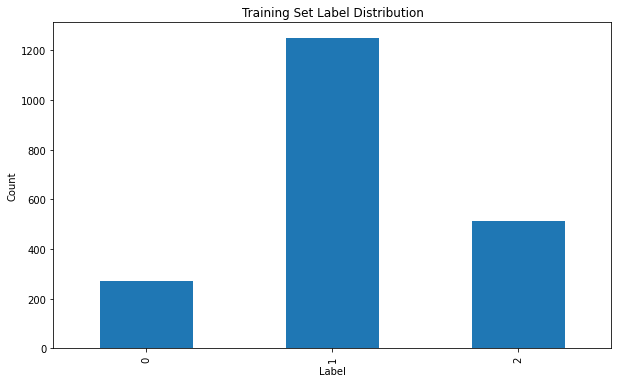

In [ ]:
# Label distribution on the training dataset
fig = plt.figure(figsize=(10,6))
plt.title('Training Set Label Distribution')
plt.xlabel('Sentiment Label')
plt.ylabel('Count')
df_train.groupby('Label').Sentence.count().plot.bar()
plt.show()

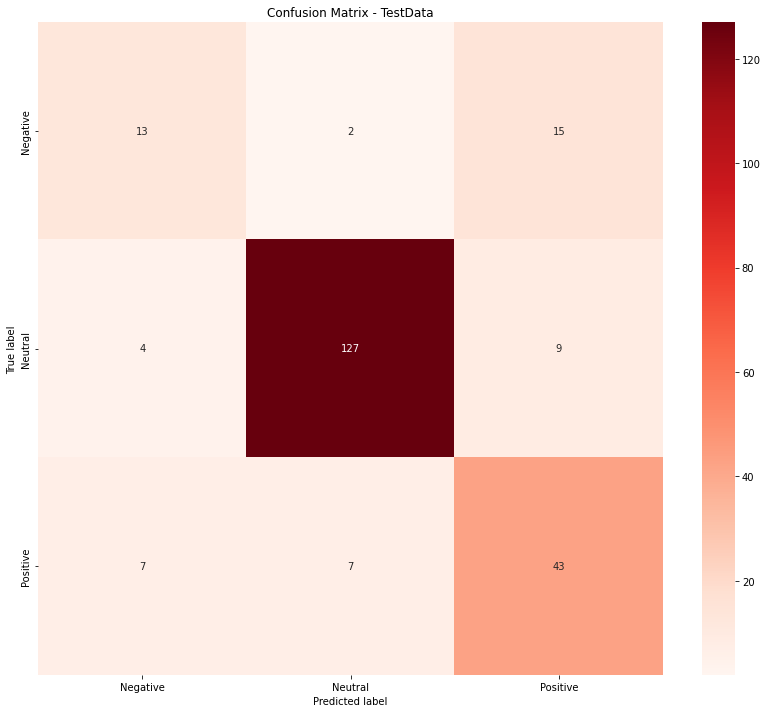

In [ ]:
# Confusion matrix for performance of model on x and y test
cm = metrics.confusion_matrix(np.argmax(Y_test, axis=1), np.argmax(model.predict(X_test),axis=1))
labels = ["Negative","Neutral","Positive"]
df_cm = pd.DataFrame(cm, index =labels, columns = labels)
fig = plt.figure(figsize=(14,12))
res = sns.heatmap(df_cm, annot=True,cmap='Reds', fmt='g')
plt.yticks([0.5,1.5,2.5], labels,va='center')
plt.title('Confusion Matrix - TestData')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()
plt.close()

In [ ]:
df_train.head()

,Sentence,Label
0,autotank group part aspo systems division,1
1,contract includes design construction delivery...,1
2,rapala said estimates make savings 12 mln eur ...,2
3,share capital alma media corporation business ...,1
4,financial impact estimated 15 meur annual impr...,2
